#**Importing libraries**

In [ ]:
import pandas as pd
import seaborn as sns
from fitter import Fitter
import numpy as np
from matplotlib import pyplot as plt
import arviz as az 
import pymc3 as pm 
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import linear_model


#**Importing data**

In [ ]:
socio = pd.read_csv("socioambiental_mun.csv", sep=';', encoding="latin1", low_memory=False,)

dengue = pd.read_csv("prevalencia_2007_2017_mun.csv", sep=';', low_memory=False,)

pop = pd.read_excel("estimativa_municipios_TCU_2015.ods",
                             sheet_name="Municípios", header=1).dropna()[["COD. UF", "NOME DO MUNICÍPIO", "POPULAÇÃO ESTIMADA"]]
pop = pop.loc[pop['COD. UF'] == 27.0]

# setting float values
socio['lixo']    = socio['lixo'].apply(lambda x: float(str(x).replace(',', '.')))
socio['esgoto']  = socio['esgoto'].apply(lambda x: float(str(x).replace(',', '.')))
socio['estudo']  = socio['estudo'].apply(lambda x: float(str(x).replace(',', '.')))
socio['salario'] = socio['salario'].apply(lambda x: float(str(x).replace(',', '.')))

# solving na values
socio.drop(socio.index[-1], axis=0, inplace=True)
socio.fillna(socio['estudo'].mean(), inplace=True)

# **Merging the datas**

Now we have data about socio-environmental, estimated population and number of dengue cases of which county, it's necessery to merge these informations and create an incidence rate.

## Merging socio-environmental and estimated population

In [ ]:
mergepop = pd.merge(pop, socio, left_on="NOME DO MUNICÍPIO", right_on="municipio").drop(
    ["COD. UF", "NOME DO MUNICÍPIO"], axis=1).rename({
        "POPULAÇÃO ESTIMADA": "pop estimada"
    }, axis=1)
mergepop

,pop estimada,municipio,lixo,esgoto,estudo,salario
0,20434,Água Branca,63.68,70.12,77.04000,93.75
1,17847,Anadia,18.35,80.93,73.81000,89.70
2,231053,Arapiraca,8.73,80.79,58.06000,91.51
3,47298,Atalaia,23.25,75.71,72.34000,90.14
4,15742,Barra de Santo Antônio,11.97,76.38,66.47000,89.95
...,...,...,...,...,...,...
97,19980,Taquarana,56.00,90.59,73.66000,94.52
98,44169,Teotônio Vilela,8.77,52.51,81.61000,91.57
99,27798,Traipu,71.45,89.71,69.95000,84.55
100,66017,União dos Palmares,20.43,34.71,70.53000,91.15


## Merging and creating the incidence rate

In [ ]:
merge_prev = pd.merge(mergepop, dengue, on='municipio', how='left')
merge_prev['total '].fillna(0, inplace=True)
merge_prev["incidence rate"] = merge_prev['total '] / merge_prev['pop estimada']
merge_prev['incidence rate'] = merge_prev['incidence rate'].astype(float)
merge_prev['incidence rate'] = round(merge_prev['incidence rate'], 3)
merge_prev.sort_values('incidence rate', ascending=False)

,pop estimada,municipio,lixo,esgoto,estudo,salario,cod,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,total,taxa incidencia
2,231053,Arapiraca,8.73,80.79,58.06,91.51,270030,2119,2097,4674,5675,3808,3857,2426,1824,1500,1517,2500,2451,34448,0.149
53,25590,Mata Grande,67.59,78.21,69.99,86.84,270500,632,353,491,527,318,91,34,31,96,107,259,422,3361,0.131
66,73878,Palmeira dos Índios,30.85,86.25,69.75,89.85,270630,425,497,1479,1905,1663,1030,460,390,329,511,719,121,9529,0.129
35,18621,Inhapi,53.25,86.21,86.24,86.73,270330,88,189,161,84,53,14,20,46,437,398,375,133,1998,0.107
49,32171,Maragogi,47.53,86.40,59.42,90.73,270450,28,108,440,761,907,421,359,103,47,38,37,20,3269,0.102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,8151,Porto de Pedras,54.11,95.37,74.59,92.55,270740,1,0,7,4,10,6,3,3,1,2,1,1,39,0.005
48,3622,Mar Vermelho,34.60,61.76,81.45,88.87,270490,1,0,2,3,2,1,3,3,0,1,0,0,16,0.004
42,4269,Jundiá,34.25,95.82,73.38,93.55,270390,3,0,0,0,2,3,5,0,0,0,1,3,17,0.004
23,56631,Coruripe,12.19,83.33,65.58,90.53,270230,14,23,28,30,29,25,43,19,14,6,4,2,237,0.004


#**Clustering the variables and creating a socio-environmental deficiency index**

Before building a predictive model, we create a socio-environmental deficiency index through principal component analysis (PCA). 

Subset including variables to be clustered

In [ ]:
subset = merge_prev[["lixo", "esgoto",	"estudo",	"salario"]]

Principal component analysis

In [ ]:
pca = PCA()
pca.fit(subset).explained_variance_ratio_

array([0.66027351, 0.24217146, 0.08827609, 0.00927894])

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(subset)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = subset.index.values
cluster_map['cluster'] = kmeans.labels_

cluster_map['cluster'].value_counts()
subset.loc[cluster_map['cluster'] == 2].describe()

merge_prev['cluster'] = kmeans.labels_

Cluster x incidence rate plot

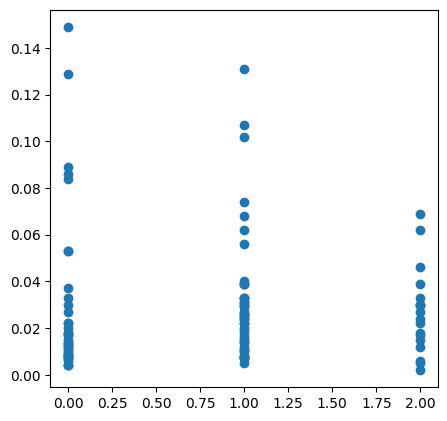

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plt.scatter(merge_prev['cluster'], merge_prev['incidence rate'])

Analysing the avarage and variance of varible values, we can index which cluster and define it's socio-environmental deficiency.

In [ ]:
merge_prev[merge_prev['cluster'] == 0][["lixo", "esgoto",	"estudo",	"salario"]].describe()

(34.601078431372535, 19.58282349543072)

In [ ]:
merge_prev[merge_prev['cluster'] == 1][["lixo", "esgoto",	"estudo",	"salario"]].describe()

In [ ]:
merge_prev[merge_prev['cluster'] == 2][["lixo", "esgoto",	"estudo",	"salario"]].describe()

In [ ]:
merge_prev[["lixo", "esgoto",	"estudo",	"salario"]].describe()

Mapping the clusters

In [ ]:
mapping = {
    0: 1, 
    1: 2, 
    2: 0, 
}
merge_prev['cluster'] = merge_prev['cluster'].apply(lambda x: mapping[x])

Groups of risk

In [ ]:
low_risk = merge_prev[merge_prev['cluster'] == 0]
medium_risk = merge_prev[merge_prev['cluster'] == 1]
high)risk = merge_prev[merge_prev['cluster'] == 2]

Histograms of the incidences of risk groups

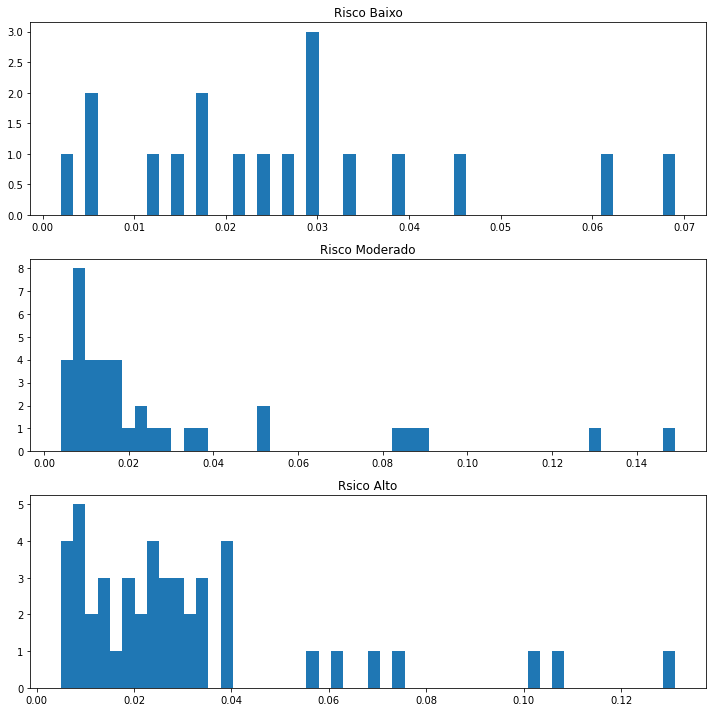

In [ ]:
fig,axes = plt.subplots(3,1,figsize=(10,10))

axes[0].hist(baixo_risco['incidence rate'], bins=50)
axes[0].set_title("Low Risk")

axes[1].hist(medio_risco['incidence rate'], bins=50)
axes[1].set_title("Medium Risk")

axes[2].hist(alto_risco['incidence rate'], bins=50)
axes[2].set_title("High Risk")

plt.tight_layout();

#**Bayesian modeling**

## Creating functions to ECDF plot

In [ ]:
def ECDF(data):
    """Compute ECDF(Empirical Distribution Function) for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)

    # x-data for the ECDF
    x = np.sort(data)

    # y-data for the ECDF
    y = np.arange(1, n+1) / n

    return x, y

def plot_samples_ecdf(ax, group_data, samples):
    # Extract just the fortis samples.
    group_samples = samples['likelihood'][:, group_data.index].flatten()
    # Compute the ECDF for the fortis samples.
    x_s, y_s = ECDF(group_samples)
    ax.plot(x_s, y_s, label='Amostra')
    
def plot_data_ecdf(ax, group_data):
    # Compute the ECDF for the fortis samples
    x, y = ECDF(group_data['taxa incidencia'])
    ax.plot(x, y, label='Dado')
    
def ax_polish(ax, title):
    ax.legend()
    ax.set_title(title)

Detectando a melhor distribuição

,sumsquare_error,aic,bic,kl_div
exponnorm,6637.783945,-162.384981,439.782103,inf
wald,6644.160214,-177.583594,435.255064,inf
invgauss,6646.791448,-171.814270,439.920423,inf
geninvgauss,6648.013750,-169.501539,444.564152,inf
fatiguelife,6664.273116,-174.661171,440.188341,inf


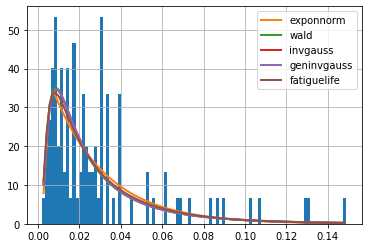

In [ ]:
f = Fitter(merge_prev['taxa incidencia'])
f.fit()
f.summary()

##Student T Likelihood

MCMC diagnostics:

*   From the following trace plot, we can visually get the plausible values of 𝜇 from the posterior.
*   We should compare this result with those from the the result we obtained analytically.




In [ ]:
merge_prev['incidence rate'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, μ]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


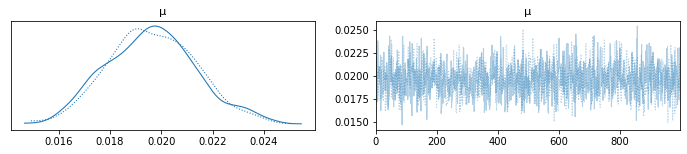

In [ ]:
with pm.Model() as model_t:
  
  μ = pm.Uniform('μ', lower=0, upper=0.15)
  σ = pm.HalfNormal('σ', sd=10)
  ν = pm.Exponential('ν', 1/1)
  y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=merge_prev['taxa incidencia'])
  trace_t = pm.sample(2000, tune=2000)

az.plot_trace(trace_t[:1000], var_names = ['μ']);



*   The left plot shows the distribution of values collected for 𝜇. What we get is a measure of uncertainty and credible values of 𝜇 between 0.016 and 0.024.
*   It is obvious that samples that have been drawn from distributions that are significantly different from the target distribution.



### Posterior predictive check

In [ ]:
ppc = pm.sample_posterior_predictive(trace_t, samples=1000, model=model_t)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([n.mean() for n in ppc['likelihood']], bins=19, alpha=0.5)
ax.axvline(merge_prev['incidence rate'].mean(), label='Mean')
ax.set(xlabel='Mean', ylabel='Frequency')
plt.legend()

The inferred mean is so far away from the actual sample mean. This confirms that Student’s t-distribution is not a proper choice for our data.

## Poisson Distribution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [μ]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


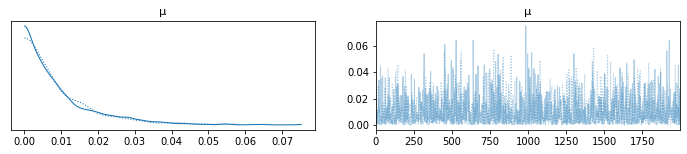

In [ ]:
with pm.Model() as model_p:
  
  μ = pm.Uniform('μ', lower=0, upper=0.15)
  
  ## Define Poisson likelihood
  y = pm.Poisson('y', mu=μ, observed=merge_prev['taxa incidencia'].values)
  trace_p = pm.sample(2000, tune=2000)

az.plot_trace(trace_p);

The measure of uncertainty and credible values of 𝜇 is between 0.00 and 0.07. Not suiteble for our data.

##Binomial Likelihood

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if __name__ == '__main__':
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [α, μ]
>Metropolis: [y_pred]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1240ad610>,
      dtype=object)

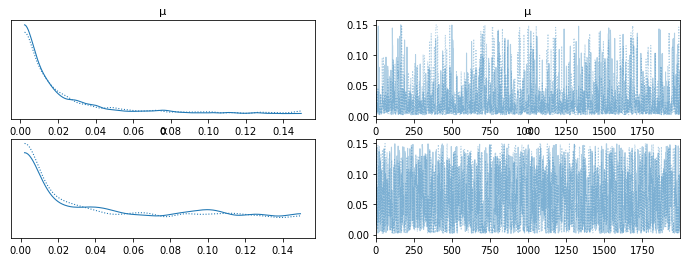

In [ ]:
with pm.Model() as model_n:
    
  μ = pm.Uniform('μ', lower=0.002, upper=0.15)
  α = pm.Uniform('α', lower=0.002, upper=0.15)

  y_pred = pm.NegativeBinomial('y_pred', mu=μ, alpha=α)
  y_est = pm.NegativeBinomial('y_est', mu=μ, alpha=α, observed=merge_prev['taxa incidencia'].values)

  trace_n = pm.sample(2000, tune=2000)

az.plot_trace(trace_n, var_names=['μ', 'α'])

Other

In [ ]:
with pm.Model() as binomial_model:
    a_prior = pm.Exponential("a_prior", lam=1/29.)
    b_prior = pm.Exponential("b_prior", lam=1/29.)
    
    p = pm.Beta("p", alpha=a_prior, beta=b_prior, shape=(len(merge_prev)))
    
    like = pm.Binomial("likelihood", p=p, n=merge_prev['novo grupo'], observed = merge_prev['taxa incidencia'])
    
    #pps = pm.Deterministic("pps", p / data['salary'])

##Inverse Gaussian Distribution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e7b22d5d0>,
      dtype=object)

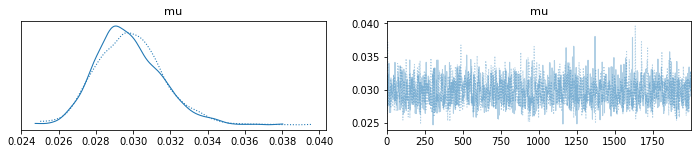

In [ ]:
with pm.Model() as model_w:
    
    #prior_sig = pm.Exponential("prior_sig", lam=0.9) 
    μ = pm.Uniform("mu", lower=0, upper=0.15)
    
    like = pm.Wald(
        "likelihood", 
        mu=μ,
        lam=0.09, #0.07 ou 0.09
        observed=merge_prev['taxa incidencia'],
    )

with model_w:
  trace_wald = pm.sample(2000, tune=2000)

az.plot_trace(trace_wald, var_names=['mu'])

The measure of uncertainty and credible values of 𝜇 is between 0.024 and 0.036 minutes, and it is very closer to the target sample mean.

###Posterior checks

**Verificando se as médias inferidas estão próximas da média amostral real**

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


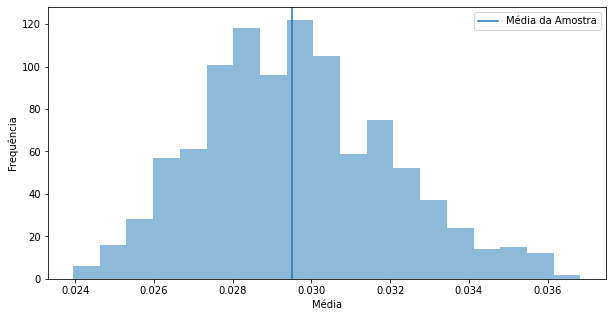

In [ ]:
ppc = pm.sample_posterior_predictive(trace_wald, samples=1000, model=model_w)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([n.mean() for n in ppc['likelihood']], bins=19, alpha=0.5)
ax.axvline(merge_prev['incidence rate'].mean(), label='Mean')
ax.set(xlabel='Mean', ylabel='Frequency')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


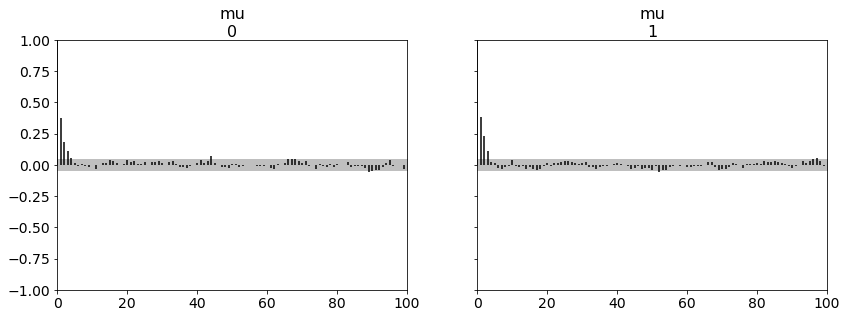

In [ ]:
_ = pm.autocorrplot(trace_wald)

We want the autocorrelation to fall as the x-axis increases in the graph. Because this indicates a low degree of correlation between our samples.

Nossas amostras do modelo de Gaussiano Inverso caíram para valores baixos de autocorrelação, o que é um bom sinal.

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
posterior predictive variable likelihood's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


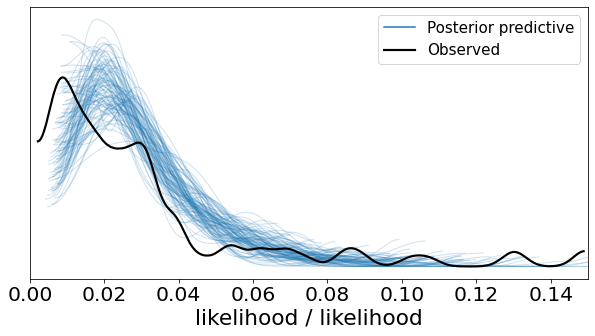

In [ ]:
y_ppc = pm.sample_posterior_predictive(trace_wald, 100, model_w, random_seed=123) 
y_pred = az.from_pymc3(trace=trace_wald, posterior_predictive=y_ppc) 
az.plot_ppc(y_pred, figsize=(10, 5), mean=False) 
plt.xlim(0, 0.15);

Using the Inverse Gaussian distribution in our model leads to predictive samples that seem to better fit the data in terms of the location of the peak of the distribution and also its spread.

The single (black) line is a kernel density estimate (KDE) of the data and the many purple lines are KDEs calculated from each of the 100 subsequent predictive samples. The blue lines reflect the uncertainty we have about the inferred distribution of the predicted data.
From the graph above, we can consider the scale of an Inverse Gaussian distribution as a reasonable practical proxy for the standard deviation of the data.

In [ ]:
az.summary(trace_wald_h)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_sig,0.060,0.065,0.013,0.141,0.001,0.001,2692.0,1872.0,1.0
mu[0],0.028,0.004,0.021,0.036,0.000,0.000,3765.0,2379.0,1.0
mu[1],0.029,0.003,0.024,0.035,0.000,0.000,4323.0,2613.0,1.0
mu[2],0.032,0.003,0.027,0.037,0.000,0.000,3936.0,2296.0,1.0


### Odds ratio

Does socio-envorinmental deficiency index of county affects incidence rate of dengue? To do it we will use the concept of odds, and we can estimate the odds ratio of socio-envorinmental vulnerability like this:

In [ ]:
stat_df = pm.summary(trace_wald_h)
stat_df['razao_probabilidade'] = np.exp(stat_df['mean'])
stat_df['efeito_percentual'] = 100 * (stat_df['razao_probabilidade'] - 1)
stat_df.sort_values('razao_probabilidade', ascending=False).to_excel('odds.xlsx')

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


We can interpret percentage_effect along those lines: “ With a one unit increase in education, the odds of subscribing to a term deposit increases by 8%. Similarly, for a one unit increase in euribor3m, the odds of subscribing to a term deposit decreases by 43%, while holding all the other independent variables constant.”